# Titanic on Vertex AI - MLOps intoductory lab

<table align="left">
  <td>
    <a>
       <img src="https://s9i7q5a6.rocketcdn.me/solutions/wp-content/uploads/2022/10/Vertex-AI-Logo.webp" style="max-width: 25%; height: auto;">
    </a>
    <a>
       <img src="https://www.science.smith.edu/climatelit/wp-content/uploads/sites/97/2024/07/GettyImages-517357578-5c4a27edc9e77c0001ccf77d-Large.jpeg" style="max-width: 38%; height: auto;">
    </a>
  </td> 
</table>

### Overview

The purpose of this notebook is to present capabilities of Vertex AI in ML models development, serving and monitoring. It covers following components:

- Exploratory Data Analysis
- Model Experimentation
- Model Training in Vertex AI
- Model Serving
- Model Monitoring (including Tensorboard)

### Import packages
Import the following packages required to execute this notebook.

In [1]:
!pip install tensorflow-io==0.31.0

In [2]:
import datetime
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import string

from google.cloud import bigquery
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score
from google.cloud import aiplatform as vertex_ai

# Set the seed fixed to make the output deterministic
tf.random.set_seed(42)

# Generate unique ID to help w/ unique naming of certain pieces
ID = "".join(random.choices(string.ascii_lowercase + string.digits, k=5))

2024-12-02 09:14:13.834220: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 09:14:15.276915: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-12-02 09:14:15.277131: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

### Setup your environment

Run the next cell to set your project ID and some of the other constants used in the lab.

In [3]:
PROJECT_ID = 'dprzek-vertex'
REGION = 'us-central1'
BUCKET_NAME = PROJECT_ID
EXPERIMENT_NAME = f"titanic-experiments-{ID}"

In [4]:
#create a Cloud Storage bucket
!gsutil mb -l {REGION} gs://{BUCKET_NAME}

Creating gs://dprzek-vertex/...
ServiceException: 409 A Cloud Storage bucket named 'dprzek-vertex' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


Take a look at the bucket you've just created: [Cloud Storage](https://console.cloud.google.com/storage/browser) page.

### Initialize clients

Next you have to initialize the Vertex AI SDK and the Python BigQuery Client for your project, region and corresponding bucket.

In [5]:
vertex_ai.init(
    project=PROJECT_ID,
    location=REGION,
    staging_bucket=f"gs://{BUCKET_NAME}",
    experiment=EXPERIMENT_NAME,
)

In [6]:
bq_client = bigquery.Client(project=PROJECT_ID, location=REGION)

### Data import and EDA

The data is imported from storage.googleapis.com - it's split on train and eval sets - we concatenate them as we require split on: train, eval and test sets later on.

In [7]:
titanic_t = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
titanic_e = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
union_data = pd.concat([titanic_t, titanic_e], ignore_index=True)

Summary of data

In [8]:
union_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   survived            891 non-null    int64  
 1   sex                 891 non-null    object 
 2   age                 891 non-null    float64
 3   n_siblings_spouses  891 non-null    int64  
 4   parch               891 non-null    int64  
 5   fare                891 non-null    float64
 6   class               891 non-null    object 
 7   deck                891 non-null    object 
 8   embark_town         891 non-null    object 
 9   alone               891 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 69.7+ KB


Examine the label distribution

<Axes: title={'center': "Count of passengers by survived label ('survived' = 0 or 1)"}, xlabel='survived', ylabel='count'>

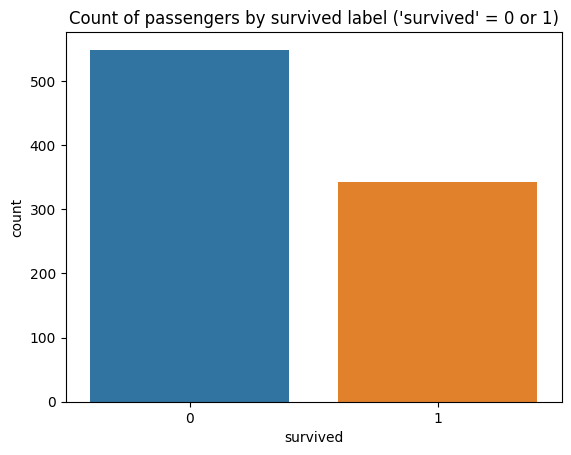

In [9]:
plt.title("Count of passengers by survived label ('survived' = 0 or 1)")
sns.countplot(x="survived", data=union_data)

And now let's take a look at continuous predictors:

In [10]:
var = list(union_data.columns)
var.remove('survived')

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'n_siblings_spouses'}>],
       [<Axes: title={'center': 'parch'}>,
        <Axes: title={'center': 'fare'}>]], dtype=object)

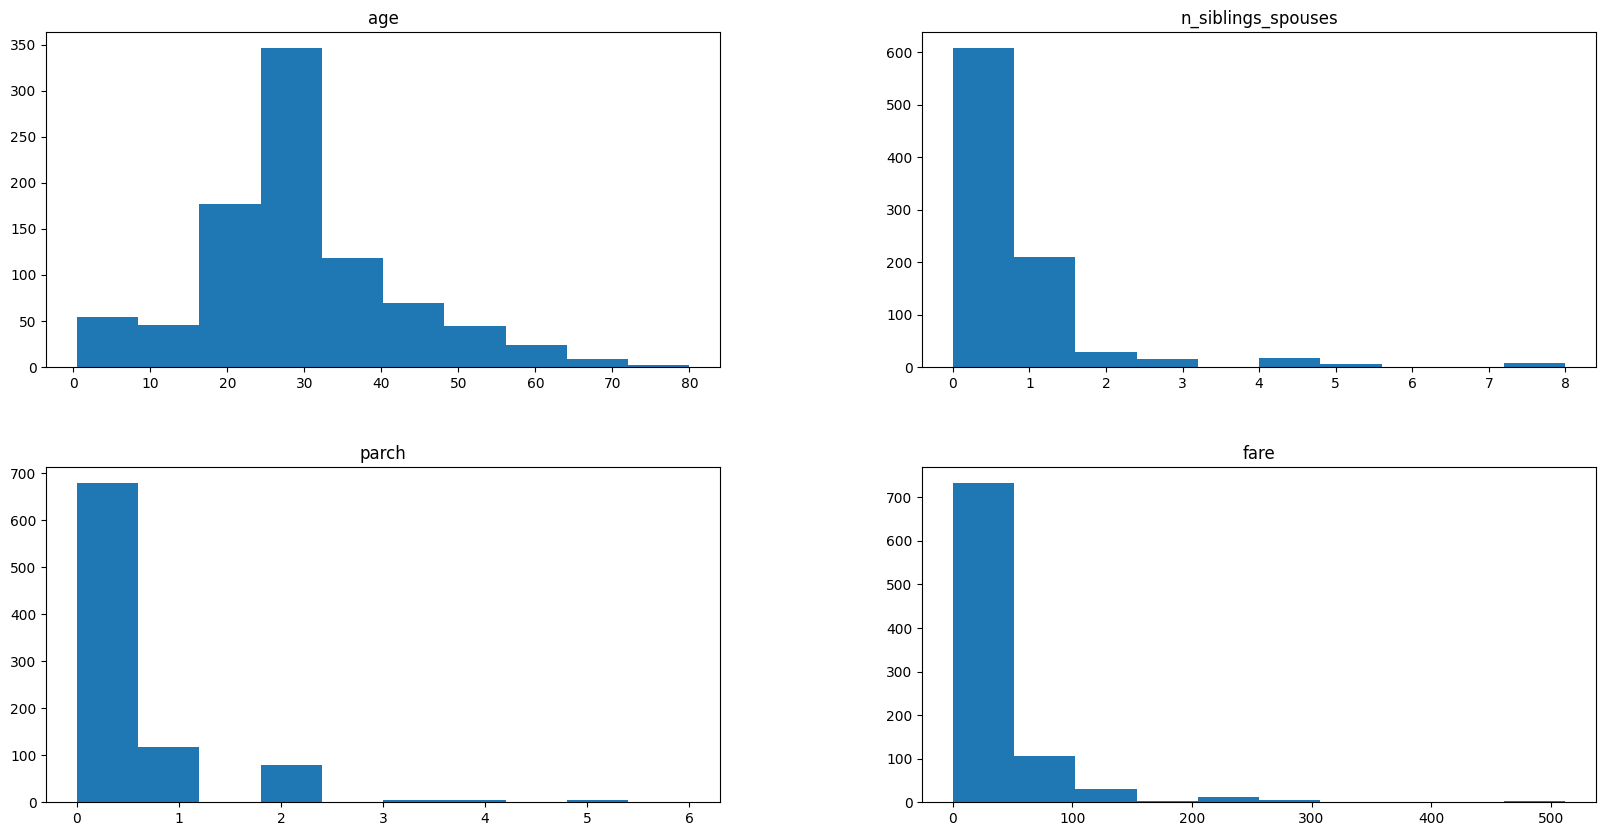

In [11]:
union_data[var].hist(figsize=(20, 10), grid=False)

And now for categorical ones:

In [12]:
categorical_vars = ['sex', 'class', 'deck', 'embark_town', 'alone'] 

In [13]:
# Create an empty dictionary to store the cross-tabulations
cross_tabs = {}

# Generate cross-tabulations for each categorical variable
for var in categorical_vars:
    cross_tabs[var] = pd.crosstab(index=union_data[var], columns='count')

# Print the cross-tabulations
for var, table in cross_tabs.items():
    print(f"Cross-tabulation for {var}:\n{table}\n")

Cross-tabulation for sex:
col_0   count
sex          
female    314
male      577

Cross-tabulation for class:
col_0   count
class        
First     216
Second    184
Third     491

Cross-tabulation for deck:
col_0    count
deck          
A           15
B           47
C           59
D           33
E           32
F           13
G            4
unknown    688

Cross-tabulation for embark_town:
col_0        count
embark_town       
Cherbourg      168
Queenstown      77
Southampton    644
unknown          2

Cross-tabulation for alone:
col_0  count
alone       
n        354
y        537



To run correlation matrix, first we run one-hot encoding:

In [14]:
union_d = pd.get_dummies(union_data, columns=['sex', 'class', 'deck', 'embark_town', 'alone'])
union_d = union_d * 1

In [15]:
variables = list(union_d.columns)
variables.remove('survived')

Correlation matrix:

<Axes: >

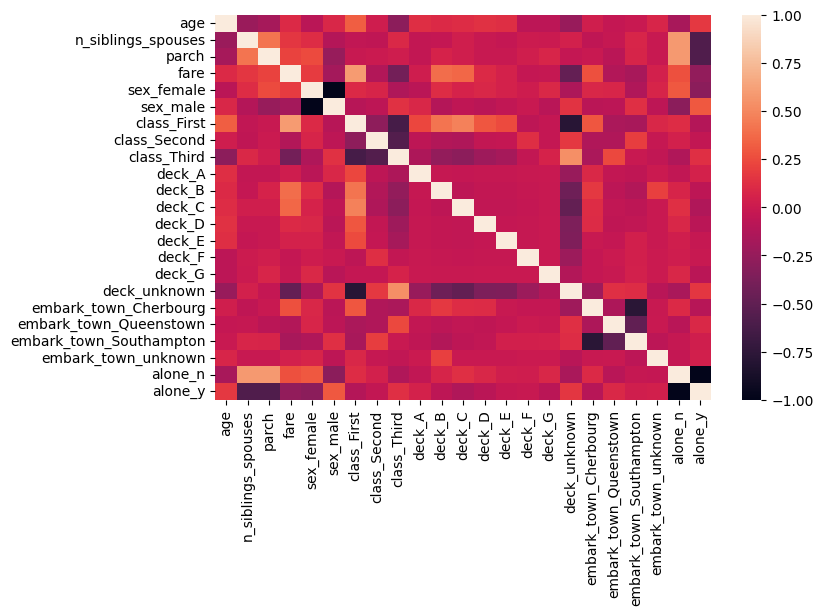

In [16]:
plt.figure(figsize=(8, 5))
sns.heatmap(union_d[variables].corr())

### Feature Engineering

There is a possibility to run feature engineering using BigQuery - let's export the data first:

In [17]:
# dataset schema
dataset_id = "dprzek-vertex.titanic_data"

dataset = bigquery.Dataset(dataset_id)
dataset.location = "us-central1"

In [18]:
# create the dataset
# dataset = bq_client.create_dataset(dataset, timeout=30)

In [19]:
# export data table
table_id = f"{dataset_id}.titanic"

job_config = bigquery.LoadJobConfig(
    autodetect=True,  
    write_disposition="WRITE_TRUNCATE"
)

union_d['age'] = union_d['age'].astype(int)
job = bq_client.load_table_from_dataframe(
    union_d, table_id, job_config=job_config
)

job.result() 

LoadJob<project=dprzek-vertex, location=us-central1, id=fbe39222-03a3-491b-a059-34f52a756659>

You can write any SQL statements you want - including creating new variables:

In [20]:
%%bigquery

SELECT
  AVG(titanic.age) AS avg_age,
  titanic.embark_town_Cherbourg,
  titanic.embark_town_Queenstown,
  titanic.embark_town_Southampton,
  titanic.embark_town_unknown
FROM
  `dprzek-vertex.titanic_data.titanic` AS titanic
GROUP BY
  2,
  3,
  4,
  5;

Query is running:   0%|          |

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,avg_age,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_unknown
0,29.231366,0,0,1,0
1,28.012987,0,1,0,0
2,30.148810,1,0,0,0
3,50.000000,0,0,0,1


### Experimenting

Before training the model, you can set some hyperparameters to help us improve the model's performance. We advise you to use Vertex AI Vizier, which automates the optimization of hyperparameters, to help with hyperparameter tuning. However, in this notebook, we specify these hyperparameters manually and randomly for the sake of simplicity and expedience.

In [21]:
# data split
train, test = train_test_split(union_d, test_size=0.2)
train, val = train_test_split(train, test_size=0.25)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

534 train examples
178 validation examples
179 test examples


#### Monitoring with tensorboard

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(variables),)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

2024-12-02 09:14:29.755227: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-12-02 09:14:29.755279: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-12-02 09:14:29.755306: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ete-model): /proc/driver/nvidia/version does not exist
2024-12-02 09:14:29.755701: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [23]:
# a utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('survived')
  # Convert features to a numpy array with the correct shape
  features = dataframe.values  
  ds = tf.data.Dataset.from_tensor_slices((features, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [24]:
batch_size = 32 
train_dataset = df_to_dataset(train, batch_size=batch_size)
val_dataset = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_dataset = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [27]:
history_model = model.fit(train_dataset, 
                                      validation_data=val_dataset,
                                      epochs=50,
                                      callbacks=[tensorboard_callback])

Epoch 1/50
17/17 [==============================] - 2s 27ms/step - loss: 1.3066 - accuracy: 0.4888 - val_loss: 1.2005 - val_accuracy: 0.6236
Epoch 2/50
17/17 [==============================] - 0s 10ms/step - loss: 1.1090 - accuracy: 0.5637 - val_loss: 0.9878 - val_accuracy: 0.6629
Epoch 3/50
17/17 [==============================] - 0s 11ms/step - loss: 1.0603 - accuracy: 0.5730 - val_loss: 0.9634 - val_accuracy: 0.6629
Epoch 4/50
17/17 [==============================] - 0s 11ms/step - loss: 0.9558 - accuracy: 0.6648 - val_loss: 0.9421 - val_accuracy: 0.6461
Epoch 5/50
17/17 [==============================] - 0s 10ms/step - loss: 0.9588 - accuracy: 0.6742 - val_loss: 0.9249 - val_accuracy: 0.6517
Epoch 6/50
17/17 [==============================] - 0s 9ms/step - loss: 0.9098 - accuracy: 0.6648 - val_loss: 0.8989 - val_accuracy: 0.6517
Epoch 7/50
17/17 [==============================] - 0s 11ms/step - loss: 0.8710 - accuracy: 0.6798 - val_loss: 0.8859 - val_accuracy: 0.6348
Epoch 8/50
17/

In [28]:
%load_ext tensorboard
%tensorboard --logdir logs/fit --port 6005

#### Registering model experiments in Vertex AI

In [29]:
parameters = [
    {"nneur1": 64, "dropout": 0.5, "nneur2": 30, "l2reg": 0.01},
    {"nneur1": 64, "dropout": 0.6, "nneur2": 20, "l2reg": 0.10},
    {"nneur1": 64, "dropout": 0.7, "nneur2": 10, "l2reg": 0.01},
    {"nneur1": 32, "dropout": 0.5, "nneur2": 30, "l2reg": 0.01},
    {"nneur1": 32, "dropout": 0.6, "nneur2": 20, "l2reg": 0.10},
    {"nneur1": 32, "dropout": 0.7, "nneur2": 10, "l2reg": 0.01},
    {"nneur1": 16, "dropout": 0.5, "nneur2": 30, "l2reg": 0.05},
    {"nneur1": 16, "dropout": 0.6, "nneur2": 20, "l2reg": 0.10},
    {"nneur1": 16, "dropout": 0.7, "nneur2": 10, "l2reg": 0.01},
]

models = {}
for i, params in enumerate(parameters):
    run_name = f"titanic-model-{ID}-{i}"
    print(run_name)
    vertex_ai.start_run(run=run_name)
    vertex_ai.log_params(params)
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(len(variables),)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(train_dataset,validation_data=val_dataset,epochs=50)
    models[run_name] = model
    
    y_pred = model.predict(test_dataset)
    y_pred = (y_pred >= 0.5).astype(int) 
    y_pred_series = pd.Series(y_pred.flatten()) 
    
    y_pred = model.predict(test_dataset)
    acc_score = accuracy_score(test['survived'], y_pred_series)
    val_f1_score = f1_score(test['survived'], y_pred_series, average="weighted")
    vertex_ai.log_metrics({"acc_score": acc_score, "f1score": val_f1_score})
    vertex_ai.end_run()

titanic-model-oxadv-0
Associating projects/672658926390/locations/us-central1/metadataStores/default/contexts/titanic-experiments-oxadv-titanic-model-oxadv-0 to Experiment: titanic-experiments-oxadv


Epoch 1/50
17/17 [==============================] - 1s 14ms/step - loss: 1.2632 - accuracy: 0.5187 - val_loss: 1.1322 - val_accuracy: 0.6461
Epoch 2/50
17/17 [==============================] - 0s 5ms/step - loss: 1.0953 - accuracy: 0.5562 - val_loss: 0.9948 - val_accuracy: 0.6629
Epoch 3/50
17/17 [==============================] - 0s 5ms/step - loss: 1.0749 - accuracy: 0.5693 - val_loss: 0.9520 - val_accuracy: 0.6461
Epoch 4/50
17/17 [==============================] - 0s 5ms/step - loss: 1.0286 - accuracy: 0.5805 - val_loss: 0.9233 - val_accuracy: 0.6404
Epoch 5/50
17/17 [==============================] - 0s 5ms/step - loss: 0.9511 - accuracy: 0.6142 - val_loss: 0.8992 - val_accuracy: 0.6461
Epoch 6/50
17/17 [==============================] - 0s 5ms/step - loss: 0.8912 - accuracy: 0.6442 - val_loss: 0.8788 - val_accuracy: 0.6461
Epoch 7/50
17/17 [==============================] - 0s 5ms/step - loss: 0.9019 - accuracy: 0.6423 - val_loss: 0.8655 - val_accuracy: 0.6404
Epoch 8/50
17/17 [=

Epoch 1/50
17/17 [==============================] - 1s 13ms/step - loss: 1.1579 - accuracy: 0.5824 - val_loss: 1.0811 - val_accuracy: 0.6461
Epoch 2/50
17/17 [==============================] - 0s 5ms/step - loss: 1.0503 - accuracy: 0.6217 - val_loss: 1.0065 - val_accuracy: 0.6517
Epoch 3/50
17/17 [==============================] - 0s 4ms/step - loss: 0.9850 - accuracy: 0.6442 - val_loss: 0.9409 - val_accuracy: 0.6348
Epoch 4/50
17/17 [==============================] - 0s 5ms/step - loss: 0.9564 - accuracy: 0.6180 - val_loss: 0.8968 - val_accuracy: 0.6517
Epoch 5/50
17/17 [==============================] - 0s 5ms/step - loss: 0.8858 - accuracy: 0.6629 - val_loss: 0.8694 - val_accuracy: 0.6517
Epoch 6/50
17/17 [==============================] - 0s 4ms/step - loss: 0.8947 - accuracy: 0.6404 - val_loss: 0.8486 - val_accuracy: 0.6517
Epoch 7/50
17/17 [==============================] - 0s 5ms/step - loss: 0.8451 - accuracy: 0.6685 - val_loss: 0.8271 - val_accuracy: 0.6573
Epoch 8/50
17/17 [=

Epoch 1/50
17/17 [==============================] - 1s 14ms/step - loss: 1.1486 - accuracy: 0.5599 - val_loss: 1.0164 - val_accuracy: 0.6573
Epoch 2/50
17/17 [==============================] - 0s 5ms/step - loss: 1.1244 - accuracy: 0.5693 - val_loss: 0.9677 - val_accuracy: 0.6629
Epoch 3/50
17/17 [==============================] - 0s 5ms/step - loss: 1.0404 - accuracy: 0.5843 - val_loss: 0.9377 - val_accuracy: 0.6573
Epoch 4/50
17/17 [==============================] - 0s 6ms/step - loss: 0.9839 - accuracy: 0.6142 - val_loss: 0.9040 - val_accuracy: 0.6573
Epoch 5/50
17/17 [==============================] - 0s 6ms/step - loss: 0.9533 - accuracy: 0.6049 - val_loss: 0.8698 - val_accuracy: 0.6629
Epoch 6/50
17/17 [==============================] - 0s 6ms/step - loss: 0.8849 - accuracy: 0.6498 - val_loss: 0.8480 - val_accuracy: 0.6461
Epoch 7/50
17/17 [==============================] - 0s 5ms/step - loss: 0.8884 - accuracy: 0.6479 - val_loss: 0.8327 - val_accuracy: 0.6461
Epoch 8/50
17/17 [=

Epoch 1/50
17/17 [==============================] - 1s 13ms/step - loss: 1.1755 - accuracy: 0.5787 - val_loss: 1.1848 - val_accuracy: 0.4382
Epoch 2/50
17/17 [==============================] - 0s 5ms/step - loss: 1.0639 - accuracy: 0.6124 - val_loss: 1.0001 - val_accuracy: 0.6573
Epoch 3/50
17/17 [==============================] - 0s 5ms/step - loss: 1.0551 - accuracy: 0.6067 - val_loss: 0.9414 - val_accuracy: 0.6404
Epoch 4/50
17/17 [==============================] - 0s 4ms/step - loss: 0.9682 - accuracy: 0.6517 - val_loss: 0.9075 - val_accuracy: 0.6404
Epoch 5/50
17/17 [==============================] - 0s 5ms/step - loss: 0.9082 - accuracy: 0.6760 - val_loss: 0.8741 - val_accuracy: 0.6404
Epoch 6/50
17/17 [==============================] - 0s 4ms/step - loss: 0.8906 - accuracy: 0.6367 - val_loss: 0.8496 - val_accuracy: 0.6517
Epoch 7/50
17/17 [==============================] - 0s 4ms/step - loss: 0.8881 - accuracy: 0.6592 - val_loss: 0.8298 - val_accuracy: 0.6461
Epoch 8/50
17/17 [=

Epoch 1/50
17/17 [==============================] - 1s 13ms/step - loss: 1.2546 - accuracy: 0.5187 - val_loss: 1.0824 - val_accuracy: 0.4438
Epoch 2/50
17/17 [==============================] - 0s 5ms/step - loss: 1.1394 - accuracy: 0.5412 - val_loss: 1.0157 - val_accuracy: 0.6124
Epoch 3/50
17/17 [==============================] - 0s 5ms/step - loss: 1.0567 - accuracy: 0.6049 - val_loss: 0.9584 - val_accuracy: 0.6404
Epoch 4/50
17/17 [==============================] - 0s 5ms/step - loss: 0.9644 - accuracy: 0.6779 - val_loss: 0.9152 - val_accuracy: 0.6573
Epoch 5/50
17/17 [==============================] - 0s 5ms/step - loss: 0.9483 - accuracy: 0.6105 - val_loss: 0.8865 - val_accuracy: 0.6461
Epoch 6/50
17/17 [==============================] - 0s 4ms/step - loss: 0.9105 - accuracy: 0.6461 - val_loss: 0.8649 - val_accuracy: 0.6461
Epoch 7/50
17/17 [==============================] - 0s 5ms/step - loss: 0.8931 - accuracy: 0.6404 - val_loss: 0.8458 - val_accuracy: 0.6404
Epoch 8/50
17/17 [=

Epoch 1/50
17/17 [==============================] - 1s 14ms/step - loss: 1.2635 - accuracy: 0.4644 - val_loss: 1.1174 - val_accuracy: 0.6180
Epoch 2/50
17/17 [==============================] - 0s 5ms/step - loss: 1.0857 - accuracy: 0.5543 - val_loss: 0.9712 - val_accuracy: 0.6573
Epoch 3/50
17/17 [==============================] - 0s 5ms/step - loss: 0.9848 - accuracy: 0.6367 - val_loss: 0.9504 - val_accuracy: 0.6685
Epoch 4/50
17/17 [==============================] - 0s 5ms/step - loss: 0.9335 - accuracy: 0.6592 - val_loss: 0.9169 - val_accuracy: 0.6461
Epoch 5/50
17/17 [==============================] - 0s 4ms/step - loss: 0.9327 - accuracy: 0.6404 - val_loss: 0.8805 - val_accuracy: 0.6517
Epoch 6/50
17/17 [==============================] - 0s 5ms/step - loss: 0.8841 - accuracy: 0.6648 - val_loss: 0.8548 - val_accuracy: 0.6461
Epoch 7/50
17/17 [==============================] - 0s 5ms/step - loss: 0.8660 - accuracy: 0.6723 - val_loss: 0.8385 - val_accuracy: 0.6517
Epoch 8/50
17/17 [=

Epoch 1/50
17/17 [==============================] - 1s 14ms/step - loss: 1.2774 - accuracy: 0.5281 - val_loss: 1.3390 - val_accuracy: 0.4213
Epoch 2/50
17/17 [==============================] - 0s 5ms/step - loss: 1.1011 - accuracy: 0.5787 - val_loss: 1.0875 - val_accuracy: 0.6348
Epoch 3/50
17/17 [==============================] - 0s 5ms/step - loss: 1.0155 - accuracy: 0.6404 - val_loss: 0.9846 - val_accuracy: 0.6404
Epoch 4/50
17/17 [==============================] - 0s 5ms/step - loss: 0.9822 - accuracy: 0.6498 - val_loss: 0.9279 - val_accuracy: 0.6348
Epoch 5/50
17/17 [==============================] - 0s 5ms/step - loss: 0.9276 - accuracy: 0.6667 - val_loss: 0.8811 - val_accuracy: 0.6404
Epoch 6/50
17/17 [==============================] - 0s 5ms/step - loss: 0.8942 - accuracy: 0.6479 - val_loss: 0.8591 - val_accuracy: 0.6461
Epoch 7/50
17/17 [==============================] - 0s 5ms/step - loss: 0.8778 - accuracy: 0.6517 - val_loss: 0.8417 - val_accuracy: 0.6461
Epoch 8/50
17/17 [=

Epoch 1/50
17/17 [==============================] - 1s 15ms/step - loss: 1.1465 - accuracy: 0.6049 - val_loss: 1.1598 - val_accuracy: 0.6517
Epoch 2/50
17/17 [==============================] - 0s 5ms/step - loss: 1.1074 - accuracy: 0.6105 - val_loss: 1.0204 - val_accuracy: 0.6461
Epoch 3/50
17/17 [==============================] - 0s 5ms/step - loss: 1.0260 - accuracy: 0.6292 - val_loss: 0.9572 - val_accuracy: 0.6461
Epoch 4/50
17/17 [==============================] - 0s 5ms/step - loss: 0.9411 - accuracy: 0.6667 - val_loss: 0.9102 - val_accuracy: 0.6461
Epoch 5/50
17/17 [==============================] - 0s 4ms/step - loss: 0.9199 - accuracy: 0.6592 - val_loss: 0.8732 - val_accuracy: 0.6404
Epoch 6/50
17/17 [==============================] - 0s 5ms/step - loss: 0.8960 - accuracy: 0.6798 - val_loss: 0.8536 - val_accuracy: 0.6461
Epoch 7/50
17/17 [==============================] - 0s 5ms/step - loss: 0.8938 - accuracy: 0.6592 - val_loss: 0.8356 - val_accuracy: 0.6404
Epoch 8/50
17/17 [=

Epoch 1/50
17/17 [==============================] - 1s 16ms/step - loss: 1.3013 - accuracy: 0.5019 - val_loss: 1.2785 - val_accuracy: 0.3933
Epoch 2/50
17/17 [==============================] - 0s 5ms/step - loss: 1.0923 - accuracy: 0.5955 - val_loss: 1.0567 - val_accuracy: 0.6629
Epoch 3/50
17/17 [==============================] - 0s 5ms/step - loss: 1.0542 - accuracy: 0.5918 - val_loss: 0.9870 - val_accuracy: 0.6292
Epoch 4/50
17/17 [==============================] - 0s 6ms/step - loss: 1.0112 - accuracy: 0.6199 - val_loss: 0.9268 - val_accuracy: 0.6404
Epoch 5/50
17/17 [==============================] - 0s 5ms/step - loss: 0.9677 - accuracy: 0.6292 - val_loss: 0.8958 - val_accuracy: 0.6292
Epoch 6/50
17/17 [==============================] - 0s 6ms/step - loss: 0.9267 - accuracy: 0.6442 - val_loss: 0.8743 - val_accuracy: 0.6461
Epoch 7/50
17/17 [==============================] - 0s 5ms/step - loss: 0.9027 - accuracy: 0.6536 - val_loss: 0.8607 - val_accuracy: 0.6573
Epoch 8/50
17/17 [=

Also, you can visualize experiments using the Cloud Console on the [Vertex AI Experiments](https://console.cloud.google.com/ai/platform/experiments/experiments) page.

### Building a ML model using Vertex AI custom training

#### Building a Vertex AI dataset

In this section,we will create a managed Vertex AI dataset. Vertex AI datasets can be used to train AutoML models or custom-trained models.

In [30]:
# create Vertex AI managed dataset
dataset = vertex_ai.TabularDataset.create(
    display_name="titanic-dataset",
    bq_source=f"bq://{table_id}",
)

Creating TabularDataset
Create TabularDataset backing LRO: projects/672658926390/locations/us-central1/datasets/6299212616447295488/operations/6769896948544569344
TabularDataset created. Resource name: projects/672658926390/locations/us-central1/datasets/6299212616447295488
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/672658926390/locations/us-central1/datasets/6299212616447295488')


Please take a look into console: [Vertex AI Datasets](https://console.cloud.google.com/vertex-ai/datasets) page.

#### Preparing model procedure for coming container

In [31]:
# create a folder for all container-related files
!mkdir -p -m 777 build_training

In [32]:
%%writefile build_training/train_model.py

# Libraries --------------------------------------------------------------------------------------------------------------------------

import datetime
import argparse
import os
import tensorflow as tf
import numpy as np
import pandas as pd

from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
from tensorflow_io.bigquery import BigQueryClient
from tensorflow_io.bigquery import BigQueryReadSession

from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score

# Variables --------------------------------------------------------------------------------------------------------------------------

def get_args():
    parser = argparse.ArgumentParser()

    # Data files arguments
    parser.add_argument("--ID", dest="ID", type=str,
                        required=True, help="generated random ID")
    parser.add_argument("--PROJECT_ID", dest="PROJECT_ID", type=str,
                        required=True, help="PROJECT_ID")
    
    return parser.parse_args()


def gcs_path_to_local_path(old_path):
    new_path = old_path.replace("gs://", "/gcs/")
    return new_path

# Read environmental variables
args = get_args()
ID = args.ID
PROJECT_ID = args.PROJECT_ID

TRAINING_DATA_PATH = os.environ["AIP_TRAINING_DATA_URI"]
TEST_DATA_PATH = os.environ["AIP_TEST_DATA_URI"]

MODEL_DIR = gcs_path_to_local_path(os.environ["AIP_MODEL_DIR"])
MODEL_PATH = MODEL_DIR

def main():

    def features_and_labels(features):
      label = features.pop('survived') # this is what we will train for
      return features, label

    def read_dataset(client, batch_size=48):
        GCP_PROJECT_ID=PROJECT_ID
        COL_NAMES = ['age', 'sex_female', 'class_First', 'class_Second', 'alone_y', 'survived']
        COL_TYPES = [dtypes.int64, dtypes.int64, dtypes.int64, dtypes.int64, dtypes.int64, dtypes.int64]
        DATASET_GCP_PROJECT_ID=PROJECT_ID
        DATASET_ID, TABLE_ID,  = 'titanic_data.titanic'.split('.')
        bqsession = client.read_session(
            "projects/" + GCP_PROJECT_ID,
            DATASET_GCP_PROJECT_ID, TABLE_ID, DATASET_ID,
            COL_NAMES, COL_TYPES,
            requested_streams=2)
        dataset = bqsession.parallel_read_rows()

        def preprocess(features):
            label = features.pop('survived')
            label = tf.cast(label, tf.int64)

            numerical_features = []

            for feature_name, feature_value in features.items():
                    numerical_features.append(feature_name)

            # Cast to tf.float64
            numerical_features = [tf.cast(features[name], tf.int64) for name in numerical_features]

            # Stack the numerical features into a 1D tensor
            concatenated_features = tf.stack(numerical_features, axis=0) 

            return concatenated_features, label  # No need for tf.expand_dims

        transformed_ds = dataset.map(preprocess)
        return transformed_ds    

    client = BigQueryClient()

    newset = read_dataset(client, 2).batch(21)
    
    model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(5,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model.fit(newset, validation_data=newset, epochs=50)

    model.save(MODEL_PATH)
    
if __name__ == "__main__":
    main()

Overwriting build_training/train_model.py


#### Building a Docker container

In [33]:
IMAGE_REPOSITORY = f"titanic-repo-{ID}"

In [34]:
IMAGE_NAME = f"classification-{ID}"
IMAGE_TAG = "v1"
IMAGE_URI = f"us-central1-docker.pkg.dev/{PROJECT_ID}/{IMAGE_REPOSITORY}/{IMAGE_NAME}:{IMAGE_TAG}"
TRAIN_COMPUTE = "e2-standard-4"
DEPLOY_COMPUTE = "n1-standard-4"

TRAIN_JOB_NAME = f"titanic-train-{ID}"

In [35]:
# Create image repository
!gcloud artifacts repositories create $IMAGE_REPOSITORY      --repository-format=docker      --location=us-central1      --description="Titanic Docker Image repository"

# List repositories under the project
!gcloud artifacts repositories list

# Get info on the repository
!gcloud artifacts repositories describe $IMAGE_REPOSITORY --location=us-central1

Create request issued for: [titanic-repo-oxadv]
Waiting for operation [projects/dprzek-vertex/locations/us-central1/operations/
23916ea6-4fc1-4bc5-b119-b44dac8e2b3f] to complete...done.                      
Created repository [titanic-repo-oxadv].
Listing items under project dprzek-vertex, across all locations.

                                                                                     ARTIFACT_REGISTRY
REPOSITORY               FORMAT  MODE                 DESCRIPTION                          LOCATION         LABELS  ENCRYPTION          CREATE_TIME          UPDATE_TIME          SIZE (MB)
knowledgeagent           DOCKER  STANDARD_REPOSITORY                                       europe-central2          Google-managed key  2024-11-04T11:36:56  2024-11-04T11:38:17  73.987
orlen-eu                 DOCKER  STANDARD_REPOSITORY                                       europe-west3             Google-managed key  2024-10-11T10:52:36  2024-10-11T10:57:38  686.260
cloud-run-source-deploy

In [36]:
!gcloud auth configure-docker us-central1-docker.pkg.dev -q


{
  "credHelpers": {
    "gcr.io": "gcloud",
    "us.gcr.io": "gcloud",
    "eu.gcr.io": "gcloud",
    "asia.gcr.io": "gcloud",
    "staging-k8s.gcr.io": "gcloud",
    "marketplace.gcr.io": "gcloud",
    "us-central1-docker.pkg.dev": "gcloud"
  }
}
Adding credentials for: us-central1-docker.pkg.dev
gcloud credential helpers already registered correctly.


In [37]:
%%writefile build_training/Dockerfile
# Specifies base image and tag
FROM python:3.7
WORKDIR /root

# Installs additional packages
RUN pip install tensorflow-io==0.31.0 tensorflow==2.11.0 gcsfs numpy pandas scikit-learn dask distributed xgboost --upgrade

# Copies the trainer code to the docker image.
COPY ./train_model.py /root/train_model.py

# Sets up the entry point to invoke the trainer.
ENTRYPOINT ["python3", "train_model.py"]

Overwriting build_training/Dockerfile


Let's take a look at [Artifact Registry](https://console.cloud.google.com/artifacts) page.

In [38]:
!docker build -t $IMAGE_URI ./build_training/
!docker push $IMAGE_URI

Sending build context to Docker daemon  6.656kB
Step 1/5 : FROM python:3.7
 ---> 16d93ae3411b
Step 2/5 : WORKDIR /root
 ---> Using cache
 ---> 274db2af2ef1
Step 3/5 : RUN pip install tensorflow-io==0.31.0 tensorflow==2.11.0 gcsfs numpy pandas scikit-learn dask distributed xgboost --upgrade
 ---> Using cache
 ---> ba7b09c2c22d
Step 4/5 : COPY ./train_model.py /root/train_model.py
 ---> Using cache
 ---> e49ca9a1368c
Step 5/5 : ENTRYPOINT ["python3", "train_model.py"]
 ---> Using cache
 ---> 2b18a5bc5f76
Successfully built 2b18a5bc5f76
Successfully tagged us-central1-docker.pkg.dev/dprzek-vertex/titanic-repo-oxadv/classification-oxadv:v1
The push refers to repository [us-central1-docker.pkg.dev/dprzek-vertex/titanic-repo-oxadv/classification-oxadv]

ac1943ba: Preparing 
f7b13770: Preparing 
30b35dba: Preparing 
f007f16f: Preparing 
2e07d5d7: Preparing 
32533a6a: Preparing 
cdeac539: Preparing 
dddd4c65: Preparing 
9095d5b5: Preparing 
cfa30cb1: Mounted from dprzek-vertex/titanic-repo-3cv

#### Training model in Vertex AI

In [39]:
MODEL_SERVING_IMAGE_URI = (
    "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-11:latest"
)

In [40]:
job = vertex_ai.CustomContainerTrainingJob(
    display_name=TRAIN_JOB_NAME,
    container_uri=IMAGE_URI,
    model_serving_container_image_uri=MODEL_SERVING_IMAGE_URI,
)

CMDARGS = [
    f"--ID={ID}",
    f"--PROJECT_ID={PROJECT_ID}",
]

In [41]:
model_vertex = job.run(
    dataset=dataset,
    model_display_name= f"titanic-vertex-{ID}",
    args=CMDARGS,
    replica_count=1,
    machine_type=TRAIN_COMPUTE,
    accelerator_count=0,
    bigquery_destination=f"bq://{PROJECT_ID}",
)

Training Output directory:
gs://dprzek-vertex/aiplatform-custom-training-2024-12-02-09:16:14.663 
No dataset split provided. The service will use a default split.
View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/5147095645114335232?project=672658926390
CustomContainerTrainingJob projects/672658926390/locations/us-central1/trainingPipelines/5147095645114335232 current state:
PipelineState.PIPELINE_STATE_RUNNING
CustomContainerTrainingJob projects/672658926390/locations/us-central1/trainingPipelines/5147095645114335232 current state:
PipelineState.PIPELINE_STATE_RUNNING
CustomContainerTrainingJob projects/672658926390/locations/us-central1/trainingPipelines/5147095645114335232 current state:
PipelineState.PIPELINE_STATE_RUNNING
CustomContainerTrainingJob projects/672658926390/locations/us-central1/trainingPipelines/5147095645114335232 current state:
PipelineState.PIPELINE_STATE_RUNNING
CustomContainerTrainingJob projects/672658926390/locations/us

Now take a look at [Model Registry](https://console.cloud.google.com/vertex-ai/models) page.

### Deploying model to endpoint

In [42]:
ENDPOINT_DISPLAY_NAME = f"titanic_endpoint_{ID}"
BQ_LOGGING_DATASET = f"titanic_log_{ID}"
BQ_LOGGING_TABLE = f"bq://{PROJECT_ID}.{BQ_LOGGING_DATASET}.req_resp"

endpoint = vertex_ai.Endpoint.create(
    display_name=ENDPOINT_DISPLAY_NAME,
    enable_request_response_logging=True,
    request_response_logging_sampling_rate=1.0,
    request_response_logging_bq_destination_table=BQ_LOGGING_TABLE,
)

# Deploy model to this endpoint
endpoint.deploy(
    model=model_vertex,
    traffic_percentage=100,
    min_replica_count=1,
    max_replica_count=1,
    machine_type="n1-standard-4",
)

Creating Endpoint
Create Endpoint backing LRO: projects/672658926390/locations/us-central1/endpoints/510464765869424640/operations/9138790352541450240
Endpoint created. Resource name: projects/672658926390/locations/us-central1/endpoints/510464765869424640
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/672658926390/locations/us-central1/endpoints/510464765869424640')
Deploying Model projects/672658926390/locations/us-central1/models/5415742379145560064 to Endpoint : projects/672658926390/locations/us-central1/endpoints/510464765869424640
Deploy Endpoint model backing LRO: projects/672658926390/locations/us-central1/endpoints/510464765869424640/operations/131591097800458240
Endpoint model deployed. Resource name: projects/672658926390/locations/us-central1/endpoints/510464765869424640


And [Endpoints](https://console.cloud.google.com/vertex-ai/online-prediction/endpoints) page.

### Setting model monitoring

In [43]:
from vertexai.resources.preview import ml_monitoring
from google.cloud.aiplatform_v1beta1.types import ExplanationSpec, ExplanationParameters, ExplanationMetadata

# Define Monitoring Schema. For AutoML models, this is optional if the schema information is available.
MONITORING_SCHEMA=ml_monitoring.spec.ModelMonitoringSchema(
  feature_fields=[
      ml_monitoring.spec.FieldSchema(
          name="age",
          data_type="integer"
      ),
      ml_monitoring.spec.FieldSchema(
          name="sex_female",
          data_type="integer"
      ),
      ml_monitoring.spec.FieldSchema(
          name="class_First",
          data_type="integer"
      ),
      ml_monitoring.spec.FieldSchema(
          name="class_Second",
          data_type="integer"
      ),
      ml_monitoring.spec.FieldSchema(
          name="alone_y",
          data_type="integer"
      )
  ],
  ground_truth_fields=[
        ml_monitoring.spec.FieldSchema(
            name="survived", 
            data_type="integer"
      )
  ],
  prediction_fields = [
      ml_monitoring.spec.FieldSchema(
          name="predicted_survived",
          data_type="integer"
      )
  ]
)

In [44]:
TRAINING_DATASET = ml_monitoring.spec.MonitoringInput(
  table_uri=f"bq://{table_id}",
)

In [45]:
FEATURE_THRESHOLDS = {
    "age": 0.003,
    "alone_y": 0.003,
    "sex_female": 0.003,
    "class_First": 0.003,
    "class_Second": 0.003,
}

In [46]:
DEFAULT_FEATURE_DRIFT_SPEC=ml_monitoring.spec.DataDriftSpec(
  categorical_metric_type="l_infinity",
  numeric_metric_type="jensen_shannon_divergence",
  default_categorical_alert_threshold=0.0001,
  default_numeric_alert_threshold=0.0001,
  feature_alert_thresholds=FEATURE_THRESHOLDS,
)

DEFAULT_PREDICTION_OUTPUT_DRIFT_SPEC=ml_monitoring.spec.DataDriftSpec(
  categorical_metric_type="l_infinity",
  numeric_metric_type="jensen_shannon_divergence",
  default_categorical_alert_threshold=0.0001,
  default_numeric_alert_threshold=0.0001,
  feature_alert_thresholds=FEATURE_THRESHOLDS,
)

DEFAULT_FEATURE_ATTRIBUTION_SPEC=ml_monitoring.spec.FeatureAttributionSpec(
    default_alert_threshold=0.0003,
    feature_alert_thresholds={"age": 0.0001},
)

In [47]:
#help(ml_monitoring.spec.DataDriftSpec)

In [48]:
DEFAULT_OUTPUT_SPEC = ml_monitoring.spec.output.OutputSpec(
  gcs_base_dir="gs://titanic-vertex"
)

DEFAULT_NOTIFICATION_SPEC = ml_monitoring.spec.NotificationSpec(
  user_emails=['dprzek@google.com']
)

In [49]:
EXPLANATION_SPEC=ExplanationSpec(
  parameters=ExplanationParameters(
      {"sampled_shapley_attribution": {"path_count": 2}}
  ),
  metadata=ExplanationMetadata(
      inputs={
            "age": ExplanationMetadata.InputMetadata(
                {
                    "input_tensor_name": "age",
                    "encoding": "IDENTITY",
                    "modality": "numeric",
                }
            ),
            "sex_female": ExplanationMetadata.InputMetadata(
                {
                    "input_tensor_name": "sex_female",
                    "encoding": "IDENTITY",
                    "modality": "numeric",
                }
            ),
             "class_First": ExplanationMetadata.InputMetadata(
                {
                    "input_tensor_name": "class_First",
                    "encoding": "IDENTITY",
                    "modality": "numeric",
                }
            ),
             "class_Second": ExplanationMetadata.InputMetadata(
                {
                    "input_tensor_name": "class_Second",
                    "encoding": "IDENTITY",
                    "modality": "numeric",
                }
            ),
            "alone_y": ExplanationMetadata.InputMetadata(
                {
                    "input_tensor_name": "alone_y",
                    "encoding": "IDENTITY",
                    "modality": "numeric",
                }
            ),
        },
        outputs={
            "survived_probs": ExplanationMetadata.OutputMetadata(
                {"output_tensor_name": "survived_probs"}
            )
        },
    ),
)

In [51]:
#help(ml_monitoring.ModelMonitor.create)
#Feature attribution - raczej pod batch
#Output prediction data drift

In [52]:
my_model_monitor_dpr = ml_monitoring.ModelMonitor.create(
  display_name=f"titanic_monitor_{ID}",
  model_name=model_vertex.resource_name,
  model_version_id="1",
  model_monitoring_schema=MONITORING_SCHEMA,
  # The following fields are optional for creating the model monitor.
  training_dataset=TRAINING_DATASET,
  tabular_objective_spec=ml_monitoring.spec.TabularObjective(
      feature_drift_spec=DEFAULT_FEATURE_DRIFT_SPEC,
      prediction_output_drift_spec=DEFAULT_PREDICTION_OUTPUT_DRIFT_SPEC,
      feature_attribution_spec=DEFAULT_FEATURE_ATTRIBUTION_SPEC,
  ),
  explanation_spec=EXPLANATION_SPEC,
  output_spec=DEFAULT_OUTPUT_SPEC,
  notification_spec=DEFAULT_NOTIFICATION_SPEC
)

Creating ModelMonitor
Create ModelMonitor backing LRO: projects/672658926390/locations/us-central1/modelMonitors/4349500873714434048/operations/8688430389804400640
ModelMonitor created. Resource name: projects/672658926390/locations/us-central1/modelMonitors/4349500873714434048
To use this ModelMonitor in another session:
model_monitor = aiplatform.ModelMonitor('projects/672658926390/locations/us-central1/modelMonitors/4349500873714434048')
https://console.cloud.google.com/vertex-ai/model-monitoring/locations/us-central1/model-monitors/4349500873714434048?project=dprzek-vertex


In [53]:
TARGET_DATASET = ml_monitoring.spec.MonitoringInput(endpoints=[endpoint.resource_name])

In [54]:
my_model_monitoring_schedule=my_model_monitor_dpr.create_schedule(
  display_name="titanic_scheduled_monitoring",
  cron="0 * * * *",
  baseline_dataset=TRAINING_DATASET,
  target_dataset=TARGET_DATASET,
  tabular_objective_spec=ml_monitoring.spec.TabularObjective(
    # Input feature drift spec.
    feature_drift_spec=DEFAULT_FEATURE_DRIFT_SPEC,
    # Prediction output drift spec.
    prediction_output_drift_spec=DEFAULT_PREDICTION_OUTPUT_DRIFT_SPEC,
  ),
)

Schedule created. Resource name: projects/672658926390/locations/us-central1/schedules/344670507028709376
To use this Schedule in another session:
schedule = aiplatform.Schedule('projects/672658926390/locations/us-central1/schedules/344670507028709376')


[Monitoring v2](https://console.cloud.google.com/vertex-ai/model-monitoring) page.

In [ ]:
num_requests = 1000

while True:
    print("Simulation started...")
    for idx in range(num_requests):
        
        request = [[99999999999999, -999999999999999, int(random.uniform(-111111119, -991)), 0, int(random.uniform(111, 11111111))] for _ in range(5000)]

        endpoint.predict(request)

        if idx % 10 == 0:
            print(f'{idx + 1} of {num_requests} prediction requests we`re invoked.')
    print("Simulation finished.")
    
    time.sleep(60*3)

Simulation started...
1 of 1000 prediction requests we`re invoked.
11 of 1000 prediction requests we`re invoked.
21 of 1000 prediction requests we`re invoked.
31 of 1000 prediction requests we`re invoked.
41 of 1000 prediction requests we`re invoked.
51 of 1000 prediction requests we`re invoked.
61 of 1000 prediction requests we`re invoked.
71 of 1000 prediction requests we`re invoked.
81 of 1000 prediction requests we`re invoked.
91 of 1000 prediction requests we`re invoked.
101 of 1000 prediction requests we`re invoked.
111 of 1000 prediction requests we`re invoked.
121 of 1000 prediction requests we`re invoked.
131 of 1000 prediction requests we`re invoked.
141 of 1000 prediction requests we`re invoked.
151 of 1000 prediction requests we`re invoked.
161 of 1000 prediction requests we`re invoked.
171 of 1000 prediction requests we`re invoked.
181 of 1000 prediction requests we`re invoked.
191 of 1000 prediction requests we`re invoked.
201 of 1000 prediction requests we`re invoked.
21